# This is a collection of all the plots used in the revised variance reduction paper

We intended for this to be online when the second round of reviews occured, but I (Philipp Griewank) forgot to push the updated code after submitting the revisions. 

As some of the experiments take up to 2 hours to run, I stored the data for the larger experiments so that the whole notebook can be run in roughly 10 minutes. The code to generate the data is all there, just commented out. 

This is not intended to be the final version of the code, that will happen once the paper revisions are completed.


### To help understand things:
$\phi$ used to be called $h$, and is still called $h$ throughout most of the code and is only relabeled at the very end


For now I will disable all save commands, and reduce the amount of experiments per timestep to speed things up 



## ToDo:



## Done


### Important parameters

In [1]:
alpha_default  = 0.1 #Reguralization coeffcient for sensitivity calculation

In [2]:
sens_loc_length = 2000 #Loclization length in meters for the sensitivity localization

In [3]:
from da_functions import *
from model_functions import *
from plot_functions import *
from misc_functions import *

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(color_codes = True)
sns.set_style('whitegrid')
import pickle

In [4]:
# I need this for some reason so that autocomplete works
%config Completer.use_jedi = False

# Running the default run that is used for the illustration plots and to generate the initial conditions for the variance reduction tests

In [5]:
"""
initialize model and data assimilation setup using the default values
"""
m_const = set_model_constants_22()
da_const = set_da_constants_22()
sat_operator = reflectance_simulator


In [6]:
%%time
# Run the model for the 100 time steps
states   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)

CPU times: user 4.86 s, sys: 129 ms, total: 4.99 s
Wall time: 1.27 s


### Plotting the first two and last three timesteps

/home/pgriewank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  


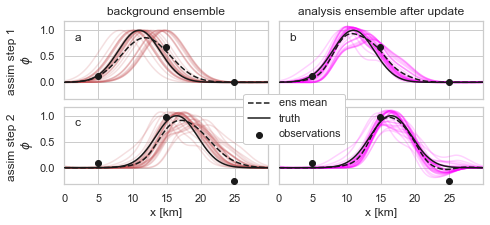

In [7]:
fig, ax = ensemble_plotter_22(states,m_const,da_const,t_start=1,t_end=3)
ax[1,0].set_xticklabels(['0','5','10','15','20','25'])
ax[0,0].set_title('background ensemble')
ax[1,0].set_xlabel('x [km]')
ax[1,1].set_xlabel('x [km]')
ax[0,0].set_ylabel('assim step 1 \n' +r'$\phi$')
ax[1,0].set_ylabel('assim step 2 \n' +r'$\phi$')
ax[1,1].legend(bbox_to_anchor=(-0.2,0.45),loc=3,framealpha=1.)
plt.subplots_adjust(wspace=0.05,hspace=0.1)
label_axes_abcd(fig,loc=(0.05,0.75))

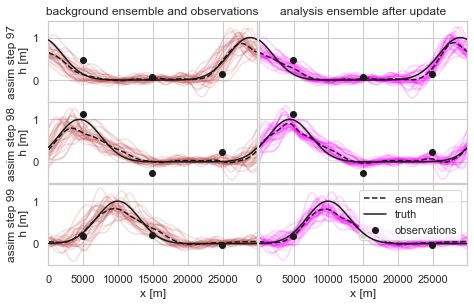

In [8]:
fig, ax = ensemble_plotter_22(states,m_const,da_const,t_start=da_const['ncyc']-3)


# plotting the indirect observations in additions to the direct observations for one timestep


In [9]:
%%time
t_step = 40
bg = states[0]['bg'][t_step]
an = states[0]['an'][t_step]
truth = states[0]['truth'][t_step]
obs = states[0]['obs'][t_step] 
obs_sat = states[0]['obs_sat'][t_step] 

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.2 µs


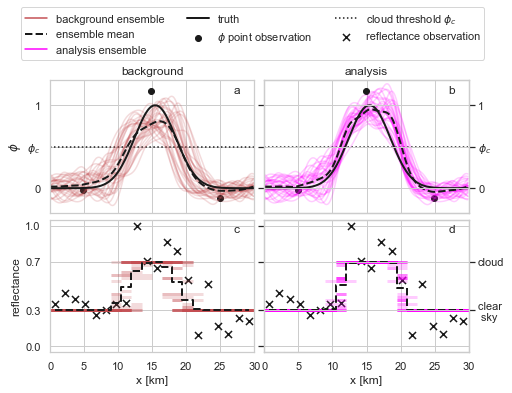

In [10]:
fig,ax = plot_ensemble_sat_analysis_paper(bg,an,obs,obs_sat,truth,reflectance_simulator,m_const,da_const,h_c=0.5)

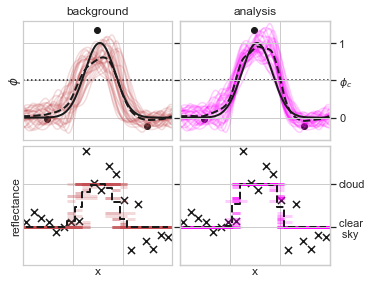

In [11]:
fig,ax = plot_ensemble_sat_analysis_abstract(bg,an,obs,obs_sat,truth,reflectance_simulator,m_const,da_const,h_c=0.5)

# Running single OSSE experiments

In [12]:

da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests

-119.38467652972545 -123.63563524670326


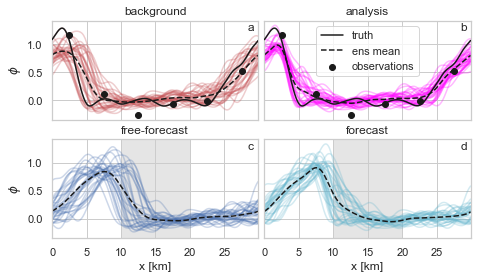

In [13]:
t_step=43
truth_idx=7
vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_vr,sat_operator,alpha=alpha_default,obs_seed=22)
fig, ax = quad_plotter_paper(quad,m_const,da_const_vr)
label_axes_abcd(fig,loc=(0.95,0.9))
print(vr_t,vr_r)

In [14]:
def plot_J_quad_paper(J_dict,quad,sens,dx,bw=0.3,dJ=True):
    """
    Plots the forecast metric distributions of the free forecast, forecast, and their linear approximations for the given sensitivity
    """
    
    fig = plt.figure(figsize=(4,3))
    nens = len(J_dict['bf'])
    dX_bg=(quad['bg'].T-np.mean(quad['bg'],axis=1)).T
    dX_an=(quad['an'].T-np.mean(quad['an'],axis=1)).T
    dX_an=dx
    dJ_ff=np.dot(sens,dX_bg)
    dJ_fc=np.dot(sens,dX_an)
    print('vr_reductions:',np.var(dJ_fc,ddof=1)-np.var(dJ_ff,ddof=1 ),np.var(J_dict['fc'],ddof=1)-np.var(J_dict['bf'],ddof=1))
    print('variance:',np.var(J_dict['bf'],ddof=1),np.var(dJ_ff,ddof=1),np.var(J_dict['fc'],ddof=1),np.var(dJ_fc,ddof=1 ))
            #'response' : np.hstack([J_dict['bf']-np.mean(J_dict['bf']),dJ_ff,J_dict['fc']-np.mean(J_dict['fc']),J_dict['es']-np.mean(J_dict['es'])]),
    if dJ:
        plot_data = {
            'response' : np.hstack([J_dict['bf']-np.mean(J_dict['bf']),dJ_ff,J_dict['fc']-np.mean(J_dict['fc']),dJ_fc]),
            'x_pos'    : np.hstack([np.zeros(nens)+0,np.zeros(nens)+1,np.zeros(nens)+2,np.zeros(nens)+3]),
            'type'     : ['blindforecast']*nens+['estimated']*nens+['forecast']*nens}
    else:
        plot_data = {
            'response' : np.hstack([J_dict['bf'],dJ_ff+np.mean(J_dict['bf']),J_dict['fc'],dJ_fc+np.mean(J_dict['fc'])]),
            'x_pos'    : np.hstack([np.zeros(nens)+0,np.zeros(nens)+1,np.zeros(nens)+2,np.zeros(nens)+3]),
            'type'     : ['blindforecast']*nens+['estimated']*nens+['forecast']*nens}

    my_pal = ["blue",  "peru","cyan","orange"  ]
        
    PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    }
    #ax = sns.violinplot(data=plot_data, inner='quartile', orient="v",cut=0,bw=bw,y='response',x='x_pos',palette=my_pal)#sns.color_palette('cool',n_colors=3))#,x='type')#,y='response',x='cyc',hue='type',,split=True,palette={dict_label[left_var]:dict_color[left_var],dict_label[right_var]:dict_color[right_var]}
    ax = sns.stripplot(data=plot_data, y='response',x='x_pos',alpha=0.7,jitter=0.15,size=5,palette=my_pal)#color='0.0')#
    #ax = sns.boxplot(data=plot_data, y='response',x='x_pos',showfliers=False,**PROPS)#,patch_artist=False)#color='0.0')#,palette=my_pal
    #plot errorbars
    plt.errorbar(np.arange(4),np.zeros(4),[np.std(J_dict['bf'],ddof=1),np.std(dJ_ff,ddof=1),np.std(J_dict['fc'],ddof=1),np.std(dJ_fc,ddof=1 )],fmt='.',capsize=15,lw=3,color='k') 
    
    #if dJ == False: ax.hlines(J_dict['tr_fc'],-0.5,2.5,'k',ls='--',label='truth'); plt.legend()
    #if dJ: ax.hlines(0,-0.5,3.5,'k',ls='--') 
    ax.set_xlim(-0.5,3.5)
    if dJ == False: ax.set_ylabel(r'$j$')
    if dJ: ax.set_ylabel(r'$\delta j$')
    ax.set_xticklabels(['free-\nforecast','estimated \n free-forecast','\n forecast','estimated \n forecast'])
    return fig, ax

vr_reductions: -119.38467652972545 -123.63563524670326
variance: 221.43278926594013 176.91208076683142 97.79715401923687 57.52740423710596


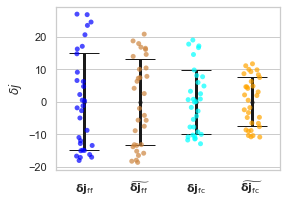

In [15]:
fig,ax = plot_J_quad_paper(J_dict,quad,dJdx_inv,dx,bw=0.2)
#ax.set_ylim(-70,55)
import matplotlib as mpl
ax.set_ylabel(r'$\mathbf{\delta j}$')
ax.set_ylabel(r'$ \delta j$')
ax.set_xticklabels([r'$\mathbf{\delta j}_\mathrm{ff}$',r'$\widetilde{\mathbf{\delta j}_\mathrm{ff}}$',r'$\mathbf{\delta j}_\mathrm{fc}$',r'$\widetilde{\mathbf{\delta j}_\mathrm{fc}}$'],va='bottom')
ax.tick_params(axis='x', pad=20)

# j evolution plot

In [16]:
t_vec=np.linspace(0,2500,100)
nt = len(t_vec)
J_ff_matrix = np.zeros([nt,da_const['nens']])
J_fc_matrix = np.zeros([nt,da_const['nens']])

t_step=43
truth_idx=7
for t in range(nt):
    da_const_vr['dt']=t_vec[t]    
    vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_vr,sat_operator,alpha=alpha_default,obs_seed=22)
    J_ff_matrix[t,:] = J_dict['bf']
    J_fc_matrix[t,:] = J_dict['fc']

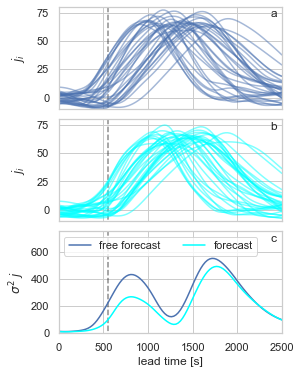

In [17]:
fig,ax = plt.subplots(3,1,figsize=(4,6),sharex='all')

bla = ax[0].plot(t_vec,J_ff_matrix,'b'   ,alpha=0.5,label='free forecast')
bla = ax[1].plot(t_vec,J_fc_matrix,'cyan',alpha=0.5,label='forecast')
ax[2].plot(t_vec,np.std(J_ff_matrix,axis=1,ddof=1)**2,'b'   ,label='free forecast')
ax[2].plot(t_vec,np.std(J_fc_matrix,axis=1,ddof=1)**2,'cyan',label='forecast')
ax[2].legend(ncol=2,loc='upper left',)
# ax[0].legend()
# ax[1].legend()
ax[0].set_ylabel(r'$j_i$')
ax[1].set_ylabel(r'$j_i$')
ax[2].set_xlabel('lead time [s]')
ax[2].set_ylabel(r'$\sigma^2$ $j$ ')
ax[2].set_ylim(bottom=0,top=750)
ax[1].set_ylim(-10,80)
ax[0].set_ylim(-10,80)
ax[2].set_xlim(0,t_vec[-1])
ax[0].vlines(550,-100,100,color='k',ls='--',alpha=0.5)
ax[1].vlines(550,-100,100,color='k',ls='--',alpha=0.5)
ax[2].vlines(550,-100,1000,color='k',ls='--',alpha=0.5)
plt.subplots_adjust(hspace=0.1)
label_axes_abcd(fig,loc=(0.95,0.9))
fig.align_ylabels()

# Sensitivity plots of the regularized sensitivity and the sensitivity which ignores crosscorrelations

We have to rerun the default run but with 512 ensemble members, and then make two OSSEs for 300 and 600 seconds.


Uncomment plot commands to see the intermediate steps plotted

In [18]:
da_const_512 = set_da_constants_22(nens=512,ncyc=t_step+1)
da_const_6   = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=512,dt=300)
da_const_62  = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=512,dt=600)
t_step=23
truth_idx=11

In [19]:
%%time
# Run the model and the single OSSEs, from which we only need the quads
states   = run_linear_advection_KF_22(m_const,da_const_512,reflectance_simulator)
vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad , dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_6,sat_operator,model_seed=505,obs_seed=55)
vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad2, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_62,sat_operator,model_seed=505,obs_seed=55)

/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  bg[:,i]    = linear_advection_model(analysis[:,i],u_ens,dhdt_ens,m_const["dx"],da_const["dt"],da_const["nt"])


CPU times: user 10.9 s, sys: 325 ms, total: 11.3 s
Wall time: 2.89 s


In [20]:


def L2_ensemble_limit(quad,nens,alpha=None,dt=0):
    """
    Simple function that calculates the sensitivity for a given quad"""
    X =quad['bg'][:,:nens]
    dX =  X.T - np.mean(X,axis=1)
    dX = dX.T
    J = np.zeros(nens)
    if dt == 0:
        X_J =quad['bg'][:,:nens]
    else:    
        X_J =quad['bf'][:,:nens]
    dX_J =  X_J.T - np.mean(X_J,axis=1)
    dX_J = dX_J.T
    for i in range(nens):
        J[i] = sum_mid_tri(X_J[:,i])
        #J[i] = sum_triangle(X_J[:,i])
    dJ = J-np.mean(J)
    B = np.cov(dX,ddof=1)
    cov_dJdX = np.dot(dJ,dX.T)/(nens-1)
    sens = L2_regularized_inversion(B,cov_dJdX,alpha=alpha)
    return sens


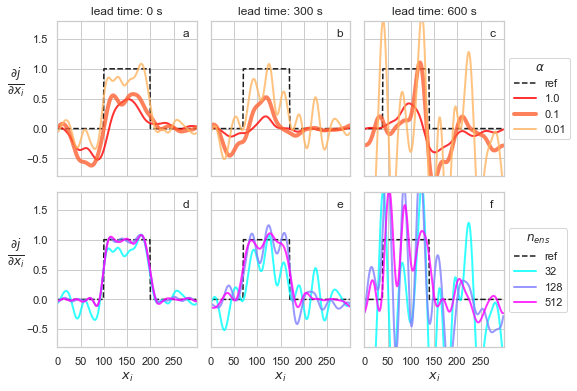

In [21]:
fig,ax = plt.subplots(2,3,sharex='all',sharey='all',figsize=(8,6))

alpha_list = [1.,0.1,0.01]
nens_list = [2**5,2**7,2**9]
#Reference lines
ax[0,0].plot([0,99,100,199,200,299],[0,0,1,1,0,0],'k--',label='ref')
ax[1,0].plot([0,99,100,199,200,299],[0,0,1,1,0,0],'k--',label='ref')

x_advected = np.array([0,99,100,199,200,299])-da_const_6['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[0,1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
ax[1,1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
x_advected = np.array([0,99,100,199,200,299])-da_const_62['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[0,2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
ax[1,2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
#ax[2,1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')

#First all the ensemble ones
n_lines = len(nens_list)
for i in range(n_lines):
    nens = nens_list[i]
    linewidth=2
#     if nens==32: linewidth=4
    ax[1,0].plot(L2_ensemble_limit(quad ,nens,dt=0,alpha=alpha_list[2]),alpha=0.8,          color=plt.cm.cool(i/(n_lines-1)),label=str(nens),linewidth=linewidth)
    ax[1,1].plot(L2_ensemble_limit(quad ,nens,dt=1,alpha=alpha_list[2]),alpha=0.8,          color=plt.cm.cool(i/(n_lines-1)),label=str(nens),linewidth=linewidth)
    ax[1,2].plot(L2_ensemble_limit(quad2,nens,dt=1,alpha=alpha_list[2]),alpha=0.8,          color=plt.cm.cool(i/(n_lines-1)),label=str(nens),linewidth=linewidth)


n_lines = len(alpha_list)
for i in range(n_lines):
    linewidth=2
    if alpha_list[i]==0.1: linewidth=4
    ax[0,0].plot(L2_ensemble_limit(quad ,32,dt=0,alpha=alpha_list[i]),alpha=0.8,color=plt.cm.rainbow_r((i)/(n_lines+5)),label=str(alpha_list[i]),linewidth=linewidth)
    ax[0,1].plot(L2_ensemble_limit(quad ,32,dt=1,alpha=alpha_list[i]),alpha=0.8,color=plt.cm.rainbow_r((i)/(n_lines+5)),label=str(alpha_list[i]),linewidth=linewidth)
    ax[0,2].plot(L2_ensemble_limit(quad2,32,dt=1,alpha=alpha_list[i]),alpha=0.8,color=plt.cm.rainbow_r((i)/(n_lines+5)),label=str(alpha_list[i]),linewidth=linewidth)

ax[0,1].set_ylim(-0.8,1.8)

ax[0,1].set_xlim(0.,300)
ax[0,1].set_xticks(50*np.arange(0,6));
plt.subplots_adjust(hspace=0.1,wspace=0.1)


ax[1,2].legend(title=r'$n_{ens}$',ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
ax[0,2].legend(title=r'$\alpha$' ,ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
ax[1,0].set_xlabel(r'$x_i$',size=13)
ax[1,1].set_xlabel(r'$x_i$',size=13)
ax[1,2].set_xlabel(r'$x_i$',size=13)
ax[0,0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=17,labelpad=10)
ax[1,0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=17,labelpad=10)

ax[0,0].set_title('lead time: 0 s')
ax[0,1].set_title('lead time: '+str(da_const_6['dt']) +' s')
ax[0,2].set_title('lead time: '+str(da_const_62['dt'])+' s')
label_axes_abcd(fig)

In [22]:
def var_ensemble_limit(quad,t,nens,dt=0,response_func = sum_mid_tri):
    """
    Looking into the cov(dJ,dX)/var(dX) simplification
    """
    X =quad['bg'][:,:nens]
    dX =  X.T - np.mean(X,axis=1)
    dX = dX.T
    J = np.zeros(nens)
    if dt == 0:
        X_J =quad['bg'][:,:nens]
    else:    
        X_J =quad['bf'][:,:nens]
    dX_J =  X_J.T - np.mean(X_J,axis=1)
    dX_J = dX_J.T
    for i in range(nens):
        J[i] = response_func(X_J[:,i])
        #J[i] = sum_triangle(X_J[:,i])
        
    dJ = J-np.mean(J)
    cov_dJdX = np.dot(dJ,dX.T)/(nens-1)
    return cov_dJdX/np.var(dX,axis=1,ddof=1)


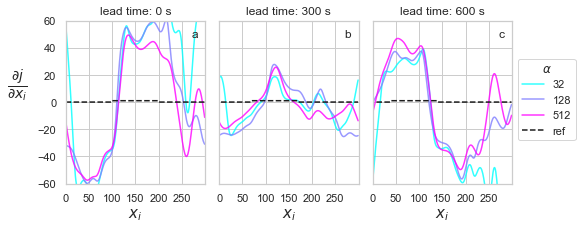

In [23]:
#Looking into the var simplification that we know doesn't work, but might be worth showing anyway 
fig,ax = plt.subplots(1,3,sharex='all',sharey='all',figsize=(8,3))
#nens_list = [2**3,2**5,2**7,2**9]
nens_list = [2**5,2**7,2**9]
n_lines = len(nens_list)
for i in range(n_lines):
    nens = nens_list[i]
    ax[0].plot(var_ensemble_limit(quad,20,nens,dt=0),alpha=0.8,color=plt.cm.cool(i/(n_lines-1)),label=str(nens))
    ax[1].plot(var_ensemble_limit(quad,20,nens,dt=1),alpha=0.8,color=plt.cm.cool(i/(n_lines-1)),label=str(nens))
    ax[2].plot(var_ensemble_limit(quad2,20,nens,dt=1),alpha=0.8,color=plt.cm.cool(i/(n_lines-1)),label=str(nens))

x_advected = np.array([0,99,100,199,200,299])-da_const_6['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
x_advected = np.array([0,99,100,199,200,299])-da_const_62['dt']*m_const['u_ref']/m_const['dx']
x_advected[-1] = 299
ax[2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')

plt.subplots_adjust(hspace=0.1,wspace=0.1)
ax[0].set_xlim(0.,300)
ax[0].set_xticks(50*np.arange(0,6));

ax[0].plot([0,99,100,199,200,299],[0,0,1,1,0,0],'k--',label='ref')
# ax[0].legend(title=r'$n_{ens}$',ncol=3,bbox_to_anchor=(0,1.0),loc='lower left')
ax[2].legend(title=r'$\alpha$' ,ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
ax[0].set_xlabel(r'$x_i$',size=15)
ax[1].set_xlabel(r'$x_i$',size=15)
ax[2].set_xlabel(r'$x_i$',size=15)
ax[0].set_title('lead time: 0 s')
ax[1].set_title('lead time: '+str(da_const_6['dt']) +' s')
ax[2].set_title('lead time: '+str(da_const_62['dt'])+' s')
ax[0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=20,labelpad=20)
ax[0].set_xlim(0.,300)
#plt.xticks(32*np.arange(9));
ax[0].set_ylim(-60,60)
label_axes_abcd(fig)

# Now making the localization advection scetch

In [24]:
"""
Reinitializing to the default values, and calculating the localization matrices
"""
m_const = set_model_constants_22()
da_const = set_da_constants_22()
L_obs,L_os = localization_matrices_observation_space(m_const,da_const)


(0.0, 30.0)

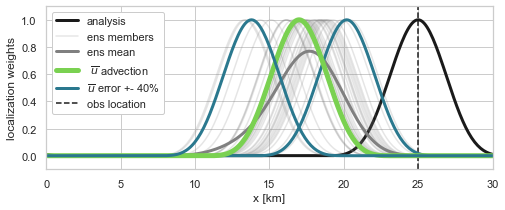

In [25]:
# This one has the plus 50 and minus 50 error, and also follows the color scheme of the other plot
o = 2
np.random.seed(2)
u_advect=10
dt = 800
L_adv_mean = semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_advect,dt)
L_adv_plus = semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_advect*1.4,dt)
L_adv_minu = semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_advect*0.6,dt)
L_adv_ens = np.zeros([m_const['nx'],da_const['nens']])
for n in range(da_const['nens']):
    u_ens = np.random.normal(m_const['u_ref'],da_const['u_std_ens'])
    L_adv_ens[:,n] =semi_lagrangian_advection(L_os[:,o],m_const['dx'],-u_ens,dt)  

    
fig, ax = plt.subplots(1,1,figsize=(8,3))


linew = (10-np.abs(60-100)/10)/2



plt.vlines(da_const['obs_loc'][o]/10+0.1,-0.1,1.1,ls='--',color='k',label='obs location')
plt.plot(m_const['x_grid']/1000+0.1,L_os[:,o],lw=3,color='k',label='analysis')
for n in range(da_const['nens']-1):
    plt.plot(m_const['x_grid']/1000+0.1,L_adv_ens[:,n],'grey',alpha=0.2)
plt.plot(m_const['x_grid']/1000+0.1,L_adv_ens[:,n+1],'grey',alpha=0.2,label='ens members')
plt.plot(m_const['x_grid']/1000+0.1,np.mean(L_adv_ens[:,:],axis=1),'grey',lw=3,label='ens mean')

plt.plot(m_const['x_grid']/1000+0.1,L_adv_minu,lw=linew,color=plt.cm.viridis((2)/(5)))
plt.plot(m_const['x_grid']/1000+0.1,L_adv_mean,lw=5,color=plt.cm.viridis((4)/(5)),label=' $\overline{u}$ advection')
plt.plot(m_const['x_grid']/1000+0.1,L_adv_plus,lw=linew,color=plt.cm.viridis((2)/(5)),label='$\overline{u}$ error +- 40%')
   
#plt.plot(m_const['x_grid']/1000,L_adv_mean,lw=3,color='r')
#plt.vlines(da_const['obs_loc'][o]/10+u_advect*dt/1000,-0.1,1.1,ls='--',color='r')
#plt.legend(loc='upper center',ncol=3)
plt.legend(framealpha=1)
ax.set_xlabel('x [km]')
ax.set_ylabel('localization weights')
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,30)

# Localized sensitivity plots

In [26]:
def loc_length_sens_comp(loc_lengths,m_const,da_const,quad,nens=32,alpha=0.1):
    """
    Calculates the sensitivity with localization.
    Localization is applied both statically and with advected localization.
    I also included sens calculated without regularization, but that is as useless as always
    """
    nlen = len(loc_lengths) 
    X =quad['bg'][:,:nens]
    dX =  X.T - np.mean(X,axis=1)
    dX = dX.T
    J = np.zeros(nens)
    X_J =quad['bf'][:,:nens]
    dX_J =  X_J.T - np.mean(X_J,axis=1)
    dX_J = dX_J.T
    for i in range(nens):
        J[i] = sum_mid_tri(X_J[:,i])
    dJ = J-np.mean(J)
    cov_dJdX = np.dot(dJ,dX.T)/(nens-1)
    B = np.cov(dX,ddof=1)
    sens_non_loc = L2_regularized_inversion(B,cov_dJdX,alpha=alpha)
    
    dji = dX_J*1
    dji[0:100,:] = 0. 
    dji[200:300,:] = 0. 

    da_const_wide = da_const.copy()
    
    sens_loc_mat        =np.zeros([m_const['nx'],nlen]) 
    sens_loc_mat_inv    =np.zeros([m_const['nx'],nlen])
    sens_loc_mat_adv    =np.zeros([m_const['nx'],nlen])   
    sens_loc_mat_adv_inv=np.zeros([m_const['nx'],nlen])   
    for n in range(nlen):
        da_const_wide['loc_length'] = loc_lengths[n]
        C = loc_matrix(da_const_wide,m_const)
        sum_loc_cov_djidX=np.sum(C*np.dot(dji,dX.T),axis=0)/(nens-1)
        sens_loc_mat[:,n]     = L2_regularized_inversion(C*B,sum_loc_cov_djidX,alpha=alpha)
        sens_loc_mat_inv[:,n] = np.dot(sum_loc_cov_djidX,np.linalg.inv(C*B))
        
        C_adv = C*1.
        for nn in range(m_const['nx']):
            C_adv[:,nn]     =semi_lagrangian_advection(C[:,nn],m_const['dx'],+m_const['u_ref']     ,da_const['dt'])
        sum_loc_cov_adv_djidX=np.sum(C_adv*np.dot(dji,dX.T),axis=0)/(nens-1)
        sens_loc_mat_adv[:,n]     = L2_regularized_inversion(C*B,sum_loc_cov_adv_djidX,alpha=alpha)
        sens_loc_mat_adv_inv[:,n] = np.dot(sum_loc_cov_djidX,np.linalg.inv(C*B))

    return sens_loc_mat,sens_loc_mat_inv,sens_loc_mat_adv,sens_loc_mat_adv_inv,sens_non_loc

In [27]:
loc_lengths= [1000,3333,10000]
t_step=24
truth_idx=20 # Irrelevant for this test
nens = 100
da_const_dt0 = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=512,dt=300)
da_const_dt1 = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=512,dt=600)
da_const_dt2 = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=512,dt=900)

vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad_dt, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_dt0,sat_operator,model_seed=505,obs_seed=55)
_,_,sens_loc_mat_adv0,_,sens_non_loc0 = loc_length_sens_comp(loc_lengths,m_const,da_const_dt0,quad_dt,nens=nens,alpha=0.1)

vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad_dt, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_dt1,sat_operator,model_seed=505,obs_seed=55)
_,_,sens_loc_mat_adv1,_,sens_non_loc1 = loc_length_sens_comp(loc_lengths,m_const,da_const_dt1,quad_dt,nens=nens,alpha=0.1)

vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad_dt, dx = vr_reloaded_22(states[0]['bg'][t_step],states[0]['bg'][t_step][:,truth_idx],m_const,da_const_dt2,sat_operator,model_seed=505,obs_seed=55)
_,_,sens_loc_mat_adv2,_,sens_non_loc2 = loc_length_sens_comp(loc_lengths,m_const,da_const_dt2,quad_dt,nens=nens,alpha=0.1)

In [28]:


def Loc_length_sens(quad,nens,loc_length,dt_adv,alpha=None,dt=0):
    """
    Simple function that calculates the sensitivity for a given quad"""
    X =quad['bg'][:,:nens]
    dX =  X.T - np.mean(X,axis=1)
    dX = dX.T
    J = np.zeros(nens)
    if dt == 0:
        X_J =quad['bg'][:,:nens]
    else:    
        X_J =quad['bf'][:,:nens]
    dX_J =  X_J.T - np.mean(X_J,axis=1)
    dX_J = dX_J.T
    for i in range(nens):
        J[i] = sum_mid_tri(X_J[:,i])
        #J[i] = sum_triangle(X_J[:,i])
    dJ = J-np.mean(J)
    B = np.cov(dX,ddof=1)
    dji = dX_J*1
    dji[0:100,:] = 0. 
    dji[200:300,:] = 0. 

    da_const_tmp = set_da_constants_22(loc_length=loc_length,dt=dt_adv)
    m_const_tmp  = set_model_constants_22()
    
    C = loc_matrix(da_const_tmp,m_const)
    C_adv = C*1.
    for nn in range(m_const['nx']):
        C_adv[:,nn]     =semi_lagrangian_advection(C[:,nn],m_const_tmp['dx'],+m_const_tmp['u_ref']     ,da_const_tmp['dt'])
    sum_loc_cov_adv_djidX=np.sum(C_adv*np.dot(dji,dX.T),axis=0)/(nens-1)
    sens_loc     = L2_regularized_inversion(C*B,sum_loc_cov_adv_djidX,alpha=alpha)
    
    return sens_loc


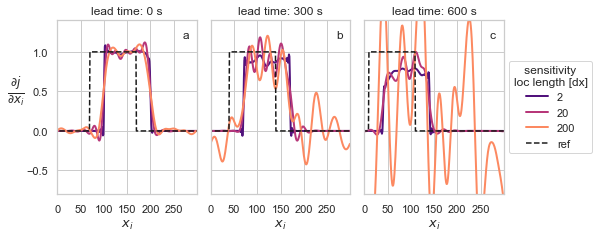

In [29]:
loc_lengths= [250,2000,16000]
loc_lengths= [200,2000,20000]
dt_adv     = [0,300,600]
alpha_val  = [0.01,0.01,0.01]
fig,axes = plt.subplots(1,3,figsize=(8,3.2),sharex='all',sharey='all')
nlen = len(loc_lengths)
for i in range(nlen):
    axes[0].plot(Loc_length_sens(quad ,32,loc_lengths[i],dt_adv[0],dt=0,alpha=alpha_val[0]) ,color=plt.cm.magma((i+1)/(nlen+1)),label=str(int(loc_lengths[i]/100.)),lw=2,alpha=1.0)
    axes[1].plot(Loc_length_sens(quad ,32,loc_lengths[i],dt_adv[1],dt=1,alpha=alpha_val[1]) ,color=plt.cm.magma((i+1)/(nlen+1)),label=str(int(loc_lengths[i]/100.)),lw=2,alpha=1.0)
    axes[2].plot(Loc_length_sens(quad2,32,loc_lengths[i],dt_adv[2],dt=1,alpha=alpha_val[2]) ,color=plt.cm.magma((i+1)/(nlen+1)),label=str(int(loc_lengths[i]/100.)),lw=2,alpha=1.0)

x_orig =np.array([0,99,100,199,200,299])*100
x_advected = x_orig-da_const_dt0['dt']*m_const['u_ref']
x_advected[-1] = 30000
x_advected = x_advected/100.
axes[0].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
x_advected = x_orig-da_const_dt1['dt']*m_const['u_ref']
x_advected[-1] = 30000
x_advected = x_advected/100.
axes[1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
x_advected = x_orig-da_const_dt2['dt']*m_const['u_ref']
x_advected[-1] = 30000
x_advected = x_advected/100.
axes[2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')


# axes[0].plot(L2_ensemble_limit(quad ,32,dt=0,alpha=alpha_val[0]),'k',label='no loc')
# axes[1].plot(L2_ensemble_limit(quad ,32,dt=1,alpha=alpha_val[1]),'k',label='no loc')
# axes[2].plot(L2_ensemble_limit(quad2,32,dt=1,alpha=alpha_val[2]),'k',label='no loc')
plt.legend(ncol=1,title='loc length [m]',bbox_to_anchor=[1,0.1],loc='lower left')
# plt.legend(title='loc length [m]',loc='lower left',ncol=2)
axes[0].set_title('lead time short')
axes[1].set_title('lead time medium')
axes[2].set_title('lead time long')
axes[2].set_xlabel('x in meter')
fig.subplots_adjust(wspace=0.1)

axes[0].set_ylim(-0.8,1.4)
axes[1].set_xlim(0.,300)
axes[1].set_xticks(50*np.arange(0,6));
axes[2].legend(title='   sensitivity \nloc length [dx]' ,ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
axes[0].set_xlabel(r'$x_i$',size=13)
axes[1].set_xlabel(r'$x_i$',size=13)
axes[2].set_xlabel(r'$x_i$',size=13)
axes[0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=17,labelpad=10)
axes[0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=17,labelpad=10)
axes[0].set_title('lead time: 0 s')
axes[1].set_title('lead time: '+str(da_const_6['dt']) +' s')
axes[2].set_title('lead time: '+str(da_const_62['dt'])+' s')
label_axes_abcd(fig)

# The incorrectly localized sensitivity plots

In [30]:
def Loc_length_sens_wrong(quad,nens,loc_length,dt_adv,alpha=None,dt=0):
    """
    Function that calculates the wrong localized sensitivities. This means once only localizing the cost function covariance, once only localizing B, and once not applying localization  
    """
    X =quad['bg'][:,:nens]
    dX =  X.T - np.mean(X,axis=1)
    dX = dX.T
    J = np.zeros(nens)
    if dt == 0:
        X_J =quad['bg'][:,:nens]
    else:    
        X_J =quad['bf'][:,:nens]
    dX_J =  X_J.T - np.mean(X_J,axis=1)
    dX_J = dX_J.T
    for i in range(nens):
        J[i] = sum_mid_tri(X_J[:,i])
        #J[i] = sum_triangle(X_J[:,i])
    dJ = J-np.mean(J)
    B = np.cov(dX,ddof=1)
    dji = dX_J*1
    dji[0:100,:] = 0. 
    dji[200:300,:] = 0. 

    da_const_tmp = set_da_constants_22(loc_length=loc_length,dt=dt_adv)
    m_const_tmp  = set_model_constants_22()
    
    C = loc_matrix(da_const_tmp,m_const)
    cov_dJdX = np.dot(dJ,dX.T)/(nens-1)
    C_adv = C*1.
    for nn in range(m_const['nx']):
        C_adv[:,nn]      =semi_lagrangian_advection(C[:,nn],m_const_tmp['dx'],+m_const_tmp['u_ref']     ,da_const_tmp['dt'])
    sum_loc_cov_adv_djidX=np.sum(C_adv*np.dot(dji,dX.T),axis=0)/(nens-1)
    sens_locB        = L2_regularized_inversion(C*B,cov_dJdX,alpha=alpha)
    sens_locJX       = L2_regularized_inversion(B,sum_loc_cov_adv_djidX,alpha=alpha)
    sens_loc_nonreg  = np.dot(np.linalg.inv(C*B),sum_loc_cov_adv_djidX)
    
    return sens_locB, sens_locJX,sens_loc_nonreg


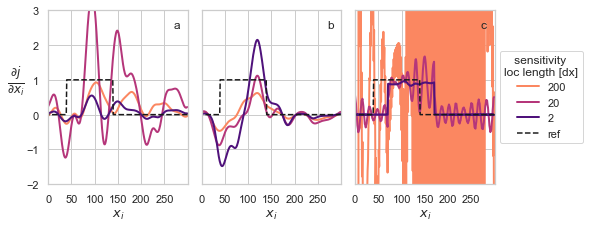

In [31]:
loc_lengths= [200,2000,20000]
loc_lengths= [20000,2000,200]
dt_adv     = 300
fig,axes = plt.subplots(1,3,figsize=(8,3.2),sharex='all',sharey='all')
nlen = len(loc_lengths)
for i in range(nlen):
    sens_locB, sens_locJX,sens_loc_nonreg = Loc_length_sens_wrong(quad ,32,loc_lengths[i],dt_adv,dt=1,alpha=0.1)
    axes[0].plot(sens_locJX      ,color=plt.cm.magma_r((i+1)/(nlen+1)),label=str(int(loc_lengths[i]/100.)),lw=2,alpha=1)
    axes[1].plot(sens_locB       ,color=plt.cm.magma_r((i+1)/(nlen+1)),label=str(int(loc_lengths[i]/100.)),lw=2,alpha=1)
    axes[2].plot(sens_loc_nonreg ,color=plt.cm.magma_r((i+1)/(nlen+1)),label=str(int(loc_lengths[i]/100.)),lw=2,alpha=1)

x_orig =np.array([0,99,100,199,200,299])*100
x_advected = x_orig-da_const_dt1['dt']*m_const['u_ref']
x_advected[-1] = 30000
x_advected = x_advected/100.
axes[0].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
axes[1].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')
axes[2].plot(x_advected,[0,0,1,1,0,0],'k--',label='ref')

plt.legend(ncol=1,title='loc length [m]',bbox_to_anchor=[1,0.1],loc='lower left')
# plt.legend(title='loc length [m]',loc='lower left',ncol=2)
# axes[0].set_title('non localized $\boldscript{B}$')
axes[1].set_title('')
axes[2].set_title('')
fig.subplots_adjust(wspace=0.1)

axes[0].set_ylim(-2,3)
axes[1].set_xlim(0.,300)
axes[1].set_xticks(50*np.arange(0,6));
axes[2].legend(title='   sensitivity \nloc length [dx]' ,ncol=1,bbox_to_anchor=(1., 0.8),loc='upper left')
axes[0].set_xlabel(r'$x_i$',size=13)
axes[1].set_xlabel(r'$x_i$',size=13)
axes[2].set_xlabel(r'$x_i$',size=13)
axes[0].set_ylabel(r'$\frac{\partial j}{\partial x_i}$',rotation=0,size=17,labelpad=10)
label_axes_abcd(fig)

# Scatterplot for two different lead times

this is relatively time consuming (roughly 2-3 minutes), but not time consuming enough for me to bother saving the data.  

In [32]:
t_start = 40
t_end = 100
n_rand = 15

In [33]:
%%time
# just resetting a
m_const = set_model_constants_22()
da_const = set_da_constants_22()
sat_operator = reflectance_simulator
da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests
# Run the model
states   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)


CPU times: user 5.27 s, sys: 104 ms, total: 5.37 s
Wall time: 1.36 s


In [34]:
%%time
import time
start_time=time.process_time()

ndt_steps=3
#t_vec=np.linspace(0,1000,ndt_steps)
t_vec=[300,1000]
n_samples = (t_end-t_start)*n_rand
truth_idx = 0
vr_es        = np.zeros([ndt_steps,n_samples])
vr_es_ca     = np.zeros([ndt_steps,n_samples])
vr_is_ca     = np.zeros([ndt_steps,n_samples])
vr_real      = np.zeros([ndt_steps,n_samples]) 
var_total    = np.zeros([ndt_steps,n_samples]) 
ref_t = da_const['dt']
counter = 0


for t in range(t_start,t_end):
    for n in range(n_rand):
        i = (t-t_start)*n_rand+n
        counter = counter+1
        truth_idx = n
        for dt in range(len(t_vec)): 
            da_const_vr['dt'] = t_vec[dt]
            
            vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
                states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
                obs_seed=i,model_seed=i,alpha=alpha_default)
            var_total[dt,i] = np.var(J_dict['bf'],ddof=1)
            vr_es[dt,i]     = vr_t
            vr_real[dt,i]   = vr_r

            vr_t, vr_i, vr_r,J_dict,dJdx_inv, bla_quad, dx = vr_reloaded_22_locsens(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,sens_loc_flag=1,
                                                                 sens_loc_length=sens_loc_length,
                                                                 obs_seed=i,model_seed=i,quad_state=quad)
            vr_es_ca[dt,i]     = vr_t
            
            vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states[0]['bg'][t],
                            states[0]['bg'][t][:,n],m_const,da_const_vr,sat_operator,
                                                    advect_flag=1,quad_state=quad,obs_seed=i,model_seed=i)
            vr_is_ca[dt,i]  = vr_t
            
            
            
    if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))

completed timesteps: 1  seconds spent computing so far: 7.0
completed timesteps: 11  seconds spent computing so far: 92.0
completed timesteps: 21  seconds spent computing so far: 175.0
completed timesteps: 31  seconds spent computing so far: 262.0
completed timesteps: 41  seconds spent computing so far: 354.0
completed timesteps: 51  seconds spent computing so far: 432.0
CPU times: user 8min 14s, sys: 10.1 s, total: 8min 25s
Wall time: 2min 6s


In [35]:
# calculating the mean properties over all experiments
es    =np.sum(vr_es    ,axis=1)/counter
es_ca =np.sum(vr_es_ca ,axis=1)/counter
is_ca =np.sum(vr_is_ca ,axis=1)/counter
real  =np.sum(vr_real  ,axis=1)/counter
total =np.sum(var_total,axis=1)/counter
me_es    =np.mean(vr_es    -vr_real,axis=1)
me_es_ca =np.mean(vr_es_ca -vr_real,axis=1)
me_is_ca =np.mean(vr_is_ca -vr_real,axis=1)

rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2),axis=1)/counter,0.5)
rmse_es_ca =np.power(np.sum(np.power((vr_es_ca -vr_real),2),axis=1)/counter,0.5)
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2),axis=1)/counter,0.5)




In [36]:
def vr_scatter_v6_v2(vr_tot1,vr_rea1,vr_tot2,vr_rea2,vr_tot3,vr_tot4,vr_tot5,vr_tot6,alpha=0.3,alpha2=0.5,color1='blueviolet',color2=plt.cm.viridis(0.8),color3='orange',
                  label1='',label2='',label3='',llabel1='explicit global',llabel2='implicit',llabel3='explicit local'):
    """
    Slightly tweaked to only have 2 times but three methods """
    
    fig, ax = plt.subplots(2,3,figsize=(8,5.5),sharex='all',sharey='all')
    
    color = color1
    vr_rea = vr_rea1
    vr_tot = vr_tot1
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[0,0].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[0,0].scatter(vr_rea,vr_tot,c=color,alpha=alpha,s=5,zorder=1,label=llabel1)
    ax[0,0].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[0,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[0,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[0,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[0,0].set_aspect('equal', 'box')
#     ax[0,0].legend(loc='lower center')
    
            
    vr_rea = vr_rea2
    vr_tot = vr_tot2
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[1,0].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[1,0].scatter(vr_rea,vr_tot,c=color,alpha=alpha,s=5,zorder=1)
    ax[1,0].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[1,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[1,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[1,0].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[1,0].set_aspect('equal', 'box')
    
    
    color = color2
    vr_rea = vr_rea1
    vr_tot = vr_tot3
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[0,1].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[0,1].scatter(vr_rea,vr_tot,c=color,alpha=alpha2,s=5,zorder=1,label=llabel2)
    ax[0,1].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[0,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[0,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[0,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[0,1].set_aspect('equal', 'box')
#     ax[0,1].legend(loc='lower center')
    
            
    vr_rea = vr_rea2
    vr_tot = vr_tot4
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[1,1].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[1,1].scatter(vr_rea,vr_tot,c=color,alpha=alpha2,s=5,zorder=1)
    ax[1,1].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[1,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[1,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[1,1].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[1,1].set_aspect('equal', 'box')
   

    color = color3
    vr_rea = vr_rea1
    vr_tot = vr_tot5
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[0,2].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[0,2].scatter(vr_rea,vr_tot,c=color,alpha=alpha2,s=5,zorder=1)
    ax[0,2].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[0,2].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[0,2].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[0,2].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[0,2].set_aspect('equal', 'box')
    
    vr_rea = vr_rea2
    vr_tot = vr_tot6
    m, b = np.polyfit(vr_rea, vr_tot, 1)
    ax[1,2].plot([-1000,1000],[-1000,1000],'k--',zorder=0)
    ax[1,2].scatter(vr_rea,vr_tot,c=color,alpha=alpha2,s=5,zorder=1)
    ax[1,2].plot(vr_rea, m*np.array(vr_rea) + b,'k',zorder=2) 
    ax[1,2].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=100,zorder=2)
    ax[1,2].scatter(np.mean(vr_rea),np.mean(vr_tot),c='k',s=50,zorder=3)
    ax[1,2].scatter(np.mean(vr_rea),np.mean(vr_tot),c='w',s=10,zorder=4)
    ax[1,2].set_aspect('equal', 'box')
    
            
    
    plt.subplots_adjust(wspace=0.05,hspace=0.05)
    
    ax[1,0].set_xlabel('variance reduction')
    ax[1,1].set_xlabel('variance reduction')
    ax[1,2].set_xlabel('variance reduction')
    ax[1,0].set_ylabel('estimated var reduction')
    ax[0,0].set_ylabel('estimated var reduction')
    
    ax[0,0].set_title(llabel1)
    ax[0,1].set_title(llabel2)
    ax[0,2].set_title(llabel3)
    
    x_max = np.max(np.hstack([vr_rea1,vr_rea2,vr_tot1,vr_tot2]))
    x_min = np.min(np.hstack([vr_rea1,vr_rea2,vr_tot1,vr_tot2]))
    
   
    ax[0,0].set_xlim(x_min,x_max)
    ax[0,0].set_ylim(x_min,x_max)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    return fig, ax


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


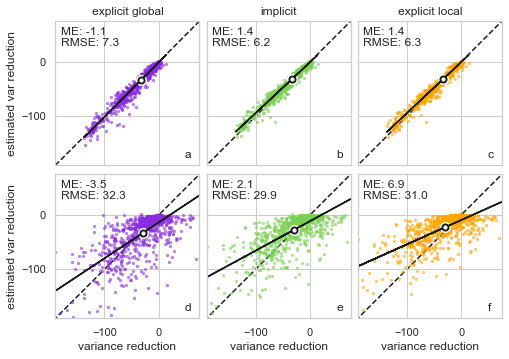

In [37]:
ind_list = [0,1]

fig,ax = vr_scatter_v6_v2(vr_es[ind_list[0],:],vr_real[ind_list[0],:],vr_es[ind_list[1],:],vr_real[ind_list[1],:],vr_is_ca[ind_list[0],:],
                       vr_is_ca[ind_list[1],:],vr_es_ca[ind_list[0],:],vr_es_ca[ind_list[1],:],
                       alpha=0.5,
                       label1='',#explicit global',
                       label2='',#implicit       ',
                       label3='')#explicit local ')
                       
#                        label1='lead time: ' +str(int(t_vec[ind_list[0]]))+' s',
#                        label2='lead time: ' +str(int(t_vec[ind_list[1]]))+' s',
#                        label3='lead time: ' +str(int(t_vec[ind_list[2]]))+' s')
ax[0,0].set_xlim(-190,75)
ax[0,0].set_ylim(-190,75)

for i in range(2):
    rmse = int(10*rmse_es[ind_list[i]])
    me = int(10*me_es[ind_list[i]])
    ax[i,0].text(-180,30,'RMSE: '+str(rmse/10),ha='left')
    ax[i,0].text(-180,50,'ME: '+str(me/10),ha='left')
for i in range(2):
    rmse = int(10*rmse_is_ca[ind_list[i]])
    me = int(10*me_is_ca[ind_list[i]])
    ax[i,1].text(-180,30,'RMSE: '+str(rmse/10),ha='left')
    ax[i,1].text(-180,50,'ME: '+str(me/10),ha='left')
for i in range(2):
    rmse = int(10*rmse_es_ca[ind_list[i]])
    me = int(10*me_es_ca[ind_list[i]])
    ax[i,2].text(-180,30,'RMSE: '+str(rmse/10),ha='left')
    ax[i,2].text(-180,50,'ME: '+str(me/10),ha='left')
label_axes_abcd(fig,loc=(0.9,0.05))

# Comparison between observations

Should also take a minute or two

In [39]:
%%time
import time
start_time=time.process_time()
da_const_sur = set_da_constants_22(obs_loc=np.arange(25,299,50),obs_loc_sat=np.array([]))
da_const_sat = set_da_constants_22(obs_loc=np.array([]))
t_start= 40
t_end = 100
n_ens = 15
# n_ens = 2
n_samples = (t_end-t_start)*n_ens
truth_idx = 0
vr_es         = np.zeros(n_samples)
vr_es_ca      = np.zeros(n_samples)
vr_is_ca      = np.zeros(n_samples)
vr_real       = np.zeros(n_samples) 
var_total     = np.zeros(n_samples) 
sat_vr_es         = np.zeros(n_samples)
sat_vr_is_ca      = np.zeros(n_samples)
sat_vr_es_ca      = np.zeros(n_samples)
sat_vr_real       = np.zeros(n_samples) 
sat_var_total     = np.zeros(n_samples) 
sur_vr_es         = np.zeros(n_samples)
sur_vr_is_ca      = np.zeros(n_samples)
sur_vr_es_ca      = np.zeros(n_samples)
sur_vr_real       = np.zeros(n_samples) 
sur_var_total     = np.zeros(n_samples) 
counter = 0
for t in range(t_start,t_end):
    for n in range(n_ens):
        i = (t-t_start)*n_ens+n
        #print(i,n_obs)
        counter = counter+1
        truth_idx = n

        # point obs
            
        vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
            states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sur,reflectance_simulator,
            obs_seed=i,model_seed=i,alpha=alpha_default)
        sur_var_total[i] = np.var(J_dict['bf'],ddof=1)
        sur_vr_es[i]     = vr_t
        sur_vr_real[i]   = vr_r
        
        vr_t, vr_r, quad, J_dict= vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sur,reflectance_simulator,
                                              advect_flag=1,obs_seed=i,model_seed=i,quad_state=quad)
        sur_vr_is_ca[i]  = vr_t
        vr_t, vr_i, vr_r,J_dict,dJdx_inv, bla_quad, dx = vr_reloaded_22_locsens(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sur,reflectance_simulator,sens_loc_flag=1,
                                                                 sens_loc_length=sens_loc_length,
                                                                 obs_seed=i,model_seed=i,quad_state=quad)
        sur_vr_es_ca[i]     = vr_t
        
        
        # sat obs
        vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
            states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sat,reflectance_simulator,
            obs_seed=i,model_seed=i,alpha=alpha_default)
        sat_var_total[i] = np.var(J_dict['bf'],ddof=1)
        sat_vr_es[i]     = vr_t
        sat_vr_real[i]   = vr_r
        
        vr_t, vr_r, quad, J_dict= vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sat,reflectance_simulator,
                                              advect_flag=1,obs_seed=i,model_seed=i,quad_state=quad)
        sat_vr_is_ca[i]  = vr_t
        vr_t, vr_i, vr_r,J_dict,dJdx_inv, bla_quad, dx = vr_reloaded_22_locsens(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_sat,reflectance_simulator,sens_loc_flag=1,
                                                                 sens_loc_length=sens_loc_length,
                                                                 obs_seed=i,model_seed=i,quad_state=quad)
        sat_vr_es_ca[i]     = vr_t
        
        
        
    if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))
       

completed timesteps: 1  seconds spent computing so far: 7.0
completed timesteps: 11  seconds spent computing so far: 79.0
completed timesteps: 21  seconds spent computing so far: 156.0
completed timesteps: 31  seconds spent computing so far: 229.0
completed timesteps: 41  seconds spent computing so far: 303.0
completed timesteps: 51  seconds spent computing so far: 362.0
CPU times: user 6min 48s, sys: 8.35 s, total: 6min 57s
Wall time: 1min 44s


In [40]:
sur_es    =np.mean(sur_vr_es    )
sur_is_ca =np.mean(sur_vr_is_ca )
sur_es_ca =np.mean(sur_vr_es_ca )
sur_real  =np.mean(sur_vr_real  )
sat_es    =np.mean(sat_vr_es    )
sat_is_ca =np.mean(sat_vr_is_ca )
sat_es_ca =np.mean(sat_vr_es_ca )
sat_real  =np.mean(sat_vr_real  )

sur_me_es    =np.mean((sur_vr_es    -sur_vr_real))
sur_me_is_ca =np.mean((sur_vr_is_ca -sur_vr_real))
sur_me_es_ca =np.mean((sur_vr_es_ca -sur_vr_real))
sat_me_es    =np.mean((sat_vr_es    -sat_vr_real))
sat_me_is_ca =np.mean((sat_vr_is_ca -sat_vr_real))
sat_me_es_ca =np.mean((sat_vr_es_ca -sat_vr_real))

sat_rmse_es    =np.power(np.sum(np.power((sat_vr_es    -sat_vr_real),2))/counter,0.5)
sat_rmse_is_ca =np.power(np.sum(np.power((sat_vr_is_ca -sat_vr_real),2))/counter,0.5)
sat_rmse_es_ca =np.power(np.sum(np.power((sat_vr_es_ca -sat_vr_real),2))/counter,0.5)
sur_rmse_es    =np.power(np.sum(np.power((sur_vr_es    -sur_vr_real),2))/counter,0.5)
sur_rmse_is_ca =np.power(np.sum(np.power((sur_vr_is_ca -sur_vr_real),2))/counter,0.5)
sur_rmse_es_ca =np.power(np.sum(np.power((sur_vr_es_ca -sur_vr_real),2))/counter,0.5)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


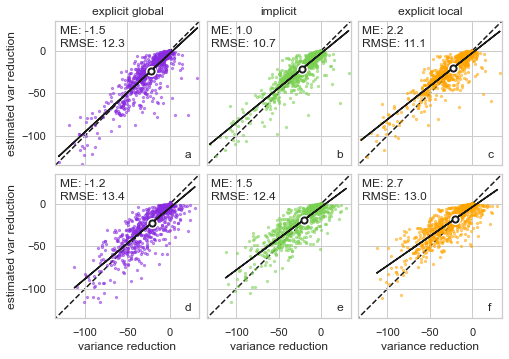

In [41]:

fig,ax = vr_scatter_v6_v2(sur_vr_es,sur_vr_real ,sat_vr_es,sat_vr_real,sur_vr_is_ca,
                       sat_vr_is_ca,sur_vr_es_ca,sat_vr_es_ca,
                       alpha=0.5,
                       label1='',#explicit global',
                       label2='',#implicit       ',
                       label3='')#explicit local ')
ax[0,0].set_xlim(-135,35)
ax[0,0].set_ylim(-135,35)

rmse = int(10*sur_rmse_es)
me   = int(10*sur_me_es)
ax[0,0].text(-130, 5,'RMSE: '+str(rmse/10),ha='left')
ax[0,0].text(-130,20,'ME: '+str(me/10),ha='left')
rmse = int(10*sat_rmse_es)
me   = int(10*sat_me_es)
ax[1,0].text(-130, 5,'RMSE: '+str(rmse/10),ha='left')
ax[1,0].text(-130,20,'ME: '+str(me/10),ha='left')

rmse = int(10*sur_rmse_is_ca)
me   = int(10*sur_me_is_ca)
ax[0,1].text(-130, 5,'RMSE: '+str(rmse/10),ha='left')
ax[0,1].text(-130,20,'ME: '+str(me/10),ha='left')
rmse = int(10*sat_rmse_is_ca)
me   = int(10*sat_me_is_ca)
ax[1,1].text(-130, 5,'RMSE: '+str(rmse/10),ha='left')
ax[1,1].text(-130,20,'ME: '+str(me/10),ha='left')

rmse = int(10*sur_rmse_es_ca)
me   = int(10*sur_me_es_ca)
ax[0,2].text(-130, 5,'RMSE: '+str(rmse/10),ha='left')
ax[0,2].text(-130,20,'ME: '+str(me/10),ha='left')
rmse = int(10*sat_rmse_es_ca)
me   = int(10*sat_me_es_ca)
ax[1,2].text(-130, 5,'RMSE: '+str(rmse/10),ha='left')
ax[1,2].text(-130,20,'ME: '+str(me/10),ha='left')

label_axes_abcd(fig,loc=(0.9,0.05))

# The variance reduction as a function of ensemble size, lead time, and analysis localization length


This is a bit of a mess because it was originally three separate plots, which where all mashed into one during the review process. On my weak laptop it takes over an hour to run the test, so here they are plotted using the stored data. But the code used to run the scripts is attached at the end of the notebook.

In [42]:
dict_raw_dt     = pickle.load(open('./plot-data/230111-raw-dict-dt.pkl','rb'))

dict_raw_analoc = pickle.load(open('./plot-data/230111-raw-dict-loclength.pkl','rb'))

dict_raw_ens    = pickle.load(open('./plot-data/230111_dict_raw_ens.pkl','rb'))

### lead time first

In [43]:

vr_es    =dict_raw_dt['vr_es   ']
vr_is_ca =dict_raw_dt['vr_is_ca']
vr_es_ca =dict_raw_dt['vr_es_ca']
vr_real  =dict_raw_dt['vr_real ']
var_total=dict_raw_dt['var_total']
t_vec    =dict_raw_dt['t_vec']

# calculating the mean properties over all experiments
es    =np.mean(vr_es    ,axis=1)
es_ca =np.mean(vr_es_ca ,axis=1)
is_ca =np.mean(vr_is_ca ,axis=1)
real  =np.mean(vr_real  ,axis=1)
total =np.mean(var_total,axis=1)
rmse_es    =np.power(np.mean(np.power((vr_es    -vr_real),2),axis=1),0.5)
rmse_es_ca =np.power(np.mean(np.power((vr_es_ca -vr_real),2),axis=1),0.5)
rmse_is_ca =np.power(np.mean(np.power((vr_is_ca -vr_real),2),axis=1),0.5)
std_real    =np.std(vr_real,axis=1)

#Lets see what changes when we change the localization used to create the background
dt_is_ca =is_ca
dt_es    =es   
dt_es_ca =es_ca
dt_real  =real 
dt_total =total
dt_rmse_is_ca= rmse_is_ca
dt_rmse_es_ca= rmse_es_ca
dt_rmse_es   = rmse_es
dt_sample_uncertainty =np.std(vr_real[:,:] ,axis=1)/np.mean(vr_real,axis=1)/np.sqrt(n_samples)
t_vec

array([   1.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
        900., 1000.])

### analysis localization length next

In [44]:
vr_es    =dict_raw_analoc['vr_es   ']
vr_is_ca =dict_raw_analoc['vr_is_ca']
vr_es_ca =dict_raw_analoc['vr_es_ca']
vr_real  =dict_raw_analoc['vr_real ']
var_total=dict_raw_analoc['var_total']
loc_values=dict_raw_analoc['loc_values']

es    =np.sum(vr_es    ,axis=1)/counter#/var_total
is_ca =np.sum(vr_is_ca ,axis=1)/counter#/var_total
es_ca =np.sum(vr_es_ca ,axis=1)/counter#/var_total
real  =np.sum(vr_real  ,axis=1)/counter#/var_total
total =np.sum(var_total,axis=1)/counter#/var_total

sample_uncertainty =np.std(vr_real[:,:] ,axis=1)/np.mean(vr_real,axis=1)/np.sqrt(n_samples)

rmse_es    =np.power(np.sum(np.power((vr_es    -vr_real),2),axis=1)/counter,0.5)#/np.sum(vr_real,axis=1)*counter
rmse_es_ca =np.power(np.sum(np.power((vr_es_ca -vr_real),2),axis=1)/counter,0.5)#/np.sum(vr_real,axis=1)*counter
rmse_is_ca =np.power(np.sum(np.power((vr_is_ca -vr_real),2),axis=1)/counter,0.5)#/np.sum(vr_real,axis=1)*counter

std_real    =np.std(vr_real,axis=1)

#Lets see what changes when we change the localization used to create the background
analoc_is_ca =is_ca
analoc_es    =es   
analoc_es_ca =es_ca
analoc_real  =real 
analoc_total =total
analoc_rmse_is_ca= rmse_is_ca
analoc_rmse_es_ca= rmse_es_ca
analoc_rmse_es   = rmse_es
analoc_sample_uncertainty =np.std(vr_real[:,:] ,axis=1)/np.mean(vr_real,axis=1)/np.sqrt(n_samples)

loc_values


array([1.000e+02, 2.000e+02, 4.000e+02, 8.000e+02, 1.600e+03, 3.200e+03,
       6.400e+03, 1.280e+04, 2.560e+04, 5.120e+04, 1.024e+05])

### and ensemble size last

In [45]:
vr_es     =dict_raw_ens['vr_es   ']
vr_is_ca  =dict_raw_ens['vr_is_ca']
vr_es_ca  =dict_raw_ens['vr_es_ca']
vr_es_reg =dict_raw_ens['vr_es_reg']
vr_real   =dict_raw_ens['vr_real ']
var_total =dict_raw_ens['var_total']
ens_values=dict_raw_ens['ens_values']

es    =np.mean(vr_es    ,axis=1)
es_reg=np.mean(vr_es_reg,axis=1)
is_ca =np.mean(vr_is_ca ,axis=1)
es_ca =np.mean(vr_es_ca ,axis=1)
real  =np.mean(vr_real  ,axis=1)
total =np.mean(var_total,axis=1)

me_es    =np.sum((vr_es    -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_is_ca =np.sum((vr_is_ca -vr_real),axis=1)/np.sum(vr_real,axis=1)
me_es_ca =np.sum((vr_es_ca -vr_real),axis=1)/np.sum(vr_real,axis=1)

rmse_es    =np.power(np.mean(np.power((vr_es    -vr_real),2),axis=1),0.5)
rmse_es_reg=np.power(np.mean(np.power((vr_es_reg-vr_real),2),axis=1),0.5)
rmse_is_ca =np.power(np.mean(np.power((vr_is_ca -vr_real),2),axis=1),0.5)
rmse_es_ca =np.power(np.mean(np.power((vr_es_ca -vr_real),2),axis=1),0.5)

#Lets see what changes when we change the localization used to create the background
ens_is_ca =is_ca
ens_es    =es   
ens_es_reg=es_reg   
ens_es_ca =es_ca
ens_real  =real 
ens_total =total 
ens_rmse_is_ca= rmse_is_ca
ens_rmse_es_ca= rmse_es_ca
ens_rmse_es   = rmse_es
ens_rmse_es_reg   = rmse_es_reg
ens_sample_uncertainty =np.std(vr_real[:,:] ,axis=1)/np.mean(vr_real,axis=1)/np.sqrt(n_samples)

ens_values


array([  4,   8,  16,  32,  64, 128, 256, 512])

### and now the plot

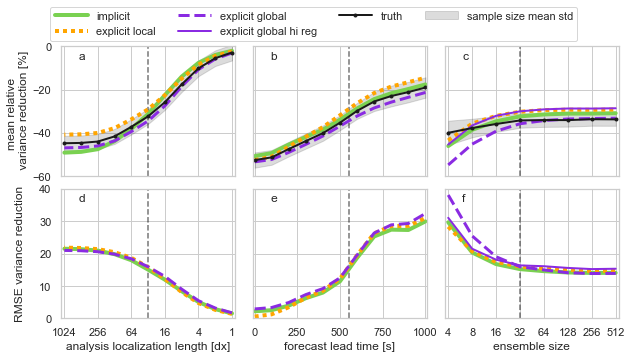

In [46]:
fig,ax = plt.subplots(2,3,figsize=(10,5),sharex='col',sharey='row')

lw_eg = 4
#localization length
ax[0,0].plot(np.arange(11,0,-1), analoc_is_ca/analoc_total*100    , lw=4    ,alpha=1.0,label='implicit'        ,color=plt.cm.viridis((4)/(6-1)))
ax[0,0].plot(np.arange(11,0,-1), analoc_es_ca/analoc_total*100    , lw=lw_eg,alpha=1.0,label='explicit local'  ,color='orange',ls=(0, (1, 1)))
ax[0,0].plot(np.arange(11,0,-1), analoc_es   /analoc_total*100    , lw=3    ,alpha=1.0,label='explicit global' ,color='blueviolet',ls='--')      
ax[0,0].plot(np.arange(11,0,-1), analoc_real /analoc_total*100    , lw=2    ,alpha=1,  color='k',ls='-',marker='.',label='truth')
ax[1,0].plot(np.arange(11,0,-1), analoc_rmse_is_ca    , lw=4    ,alpha=1.0,label='implicit'        ,color=plt.cm.viridis((4)/(6-1)))
ax[1,0].plot(np.arange(11,0,-1), analoc_rmse_es_ca    , lw=lw_eg,alpha=1.0,label='explicit local'  ,color='orange',ls=(0, (1, 1)))
ax[1,0].plot(np.arange(11,0,-1), analoc_rmse_es       , lw=3    ,alpha=1.0,label='explicit global' ,color='blueviolet',ls='--')      
ax[1,0].set_xticks(np.arange(1,12,2));
ax[1,0].set_xticklabels(2**np.arange(10,-1,-2));
ax[1,0].set_xlim(left=0.8,right=11.2)
ax[1,0].set_xlabel('analysis localization length [dx]');
ax[0,0].set_ylabel('mean relative \n variance reduction [%]');
# ax[0,0].set_title('localization length');
ax[1,0].set_ylabel('RMSE variance reduction',labelpad=14);

# ax[0,0].errorbar(np.arange(11,0,-1),analoc_real /analoc_total*100   ,yerr=analoc_sample_uncertainty*100,color='k',label='truth',capsize=5)
ax[0,0].fill_between(np.arange(11,0,-1),analoc_real /analoc_total*100  -analoc_sample_uncertainty*100 ,analoc_real /analoc_total*100+analoc_sample_uncertainty*100,color='k',alpha=0.15,label='sample size mean std')

# lead time
ax[0,1].plot(t_vec, dt_is_ca/dt_total*100    , lw=4    ,alpha=1.0,label='implicit'        ,color=plt.cm.viridis((4)/(6-1)))
ax[0,1].plot(t_vec, dt_es_ca/dt_total*100    , lw=lw_eg,alpha=1.0,label='explicit local'  ,color='orange',ls=(0, (1, 1)))
ax[0,1].plot(t_vec, dt_es   /dt_total*100    , lw=3    ,alpha=1.0,label='explicit global' ,color='blueviolet',ls='--')      
ax[0,1].plot(t_vec, dt_real /dt_total*100    , lw=2    ,alpha=1,  color='k',ls='-',marker='.',label='truth')
ax[1,1].plot(t_vec, dt_rmse_is_ca    , lw=4    ,alpha=1.0,label='implicit'        ,color=plt.cm.viridis((4)/(6-1)))
ax[1,1].plot(t_vec, dt_rmse_es_ca    , lw=lw_eg,alpha=1.0,label='explicit local'  ,color='orange',ls=(0, (1, 1)))
ax[1,1].plot(t_vec, dt_rmse_es       , lw=3    ,alpha=1.0,label='explicit global' ,color='blueviolet',ls='--')      
ax[1,1].set_xlabel('forecast lead time [s]');
ax[1,1].set_xlim(left=-10,right=1010)
# ax[0,1].set_title('forecast lead time');

ax[0,1].fill_between(t_vec,dt_real /dt_total*100  -dt_sample_uncertainty*100 ,dt_real /dt_total*100+dt_sample_uncertainty*100,color='k',alpha=0.15,label='sample size mean std')

# loc length
ax[0,2].plot(ens_values, ens_is_ca/ens_total*100    , lw=4    ,alpha=1.0,label='implicit'        ,color=plt.cm.viridis((4)/(6-1)))
ax[0,2].plot(ens_values, ens_es_ca/ens_total*100    , lw=lw_eg,alpha=1.0,label='explicit local'  ,color='orange',ls=(0, (1, 1)))
ax[0,2].plot(ens_values, ens_es   /ens_total*100    , lw=3    ,alpha=1.0,label='explicit global' ,color='blueviolet',ls='--')      
ax[0,2].plot(ens_values, ens_es_reg/ens_total*100    , lw=2    ,alpha=1.0,label='explicit global hi reg' ,color='blueviolet',ls='-')      
ax[0,2].plot(ens_values, ens_real /ens_total*100    , lw=2    ,alpha=1,  color='k',ls='-',marker='.',label='truth')
ax[1,2].plot(ens_values, ens_rmse_is_ca    , lw=4    ,alpha=1.0,label='implicit'        ,color=plt.cm.viridis((4)/(6-1)))
ax[1,2].plot(ens_values, ens_rmse_es_ca    , lw=lw_eg,alpha=1.0,label='explicit local'  ,color='orange',ls=(0, (1, 1)))
ax[1,2].plot(ens_values, ens_rmse_es       , lw=3    ,alpha=1.0,label='explicit global' ,color='blueviolet',ls='--')      
ax[1,2].plot(ens_values, ens_rmse_es_reg   , lw=2    ,alpha=1.0,label='explicit global hi reg'  ,color='blueviolet')
# ax[0,2].set_title('ensemble size');

ax[0,2].fill_between(ens_values,ens_real /ens_total*100  -ens_sample_uncertainty*100 ,ens_real /ens_total*100+ens_sample_uncertainty*100,color='k',alpha=0.15,label='sample size mean std')

#Adding the default setting lines
ax[0,0].vlines(  6,-60,0,'k',ls='--',alpha=0.6)
ax[0,1].vlines(550,-60,0,'k',ls='--',alpha=0.6)
ax[0,2].vlines( 32,-60,0,'k',ls='--',alpha=0.6)

ax[1,0].vlines(  6,0,50,'k',ls='--',alpha=0.6)
ax[1,1].vlines(550,0,50,'k',ls='--',alpha=0.6)
ax[1,2].vlines( 32,0,50,'k',ls='--',alpha=0.6)



ax[0,2].set_xscale('log');
ax[0,2].set_xticks(ens_values);
ax[0,2].set_xticklabels(ens_values);
ax[1,2].set_xlabel('ensemble size');

ax[1,2].set_xlim(left=0.9*4,right=512*1.1)
# ax[1,2].set_xlim(left=4,right=128)
ax[1,1].set_ylim(bottom=0,top=40)
ax[0,0].set_ylim(top=0,bottom=-60)
#ax[0,0].legend(bbox_to_anchor=(0.,1.00,0.5,3),loc='lower left',ncol=5,handlelength=2);
ax[0,2].legend(bbox_to_anchor=(-1.,1.00,0.5,3),loc='lower center',ncol=4,handlelength=3);
plt.subplots_adjust(wspace=0.1,hspace=0.1)
label_axes_abcd(fig,loc=(0.1,0.9))

# Next up testing for different regularization parameters alpha

This takes long enough (hour), that I will simply load the data instead of running it by default 


In [47]:
# %%time
# da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50))

# nalpha_steps=23
# alpha_vec=np.logspace(-9,2,nalpha_steps)
# t_vec=np.array([200,600,1000,1400,1800])
# ndt_steps=len(t_vec)
# t_start= 40
# t_end = 100
# n_rand = 15
# n_samples = (t_end-t_start)*n_rand
# sens_all     = np.zeros([ndt_steps,300])
# vr_es_alpha  = np.zeros([nalpha_steps,ndt_steps,n_samples])
# vr_real      = np.zeros([ndt_steps,n_samples]) 
# var_total     = np.zeros([ndt_steps,n_samples]) 
# counter = 0
# total_variance = 0.
# for t in range(t_start,t_end):
#     for r in range(n_rand):
#         n = (t-t_start)*n_rand+r
#         np.random.seed(n)
#         #print(i,n_obs)
#         counter = counter+1
#         truth_idx = r
#         for i in range(len(t_vec)): 
#             da_const_vr['dt'] = t_vec[i]
            
            
#             for a in range(nalpha_steps):
#                 if a ==0:
#                     vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states[0]['bg'][t],
#                     states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,iterative_flag = 0,
#                     alpha=alpha_vec[a],obs_seed=counter,model_seed=counter)
#                 else:
#                     vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states[0]['bg'][t],
#                     states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,iterative_flag = 0,
#                     alpha=alpha_vec[a],obs_seed=counter,model_seed=counter,quad_state=quad)
            
#                 vr_es_alpha[a,i,n]  = vr_t
#             var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
#             vr_real[i,n]   = vr_r
            
            
            
#     print('completed t:',t)
       

### loading raw data

In [48]:
a_file = open("plot-data/alpha_OSSEs.pkl",'rb')
bla=pickle.load(a_file)
dict_raw=bla
a_file.close()
vr_es_alpha=dict_raw['vr_es-alpha']
vr_real    =dict_raw['vr_real ']
var_total  =dict_raw['var_total']
t_vec      =dict_raw['t_vec']
alpha_vec  =dict_raw['alpha_vec']

counter = vr_real.shape[1]
nalpha_steps = vr_es_alpha.shape[0]
nalpha_steps=23
alpha_vec=np.logspace(-9,2,nalpha_steps)
t_vec=np.array([200,600,1000,1400,1800])
ndt_steps=len(t_vec)

In [49]:
real  =np.sum(vr_real  ,axis=1)/counter#/var_total
total =np.sum(var_total,axis=1)/counter#/var_total

rmse_es_alpha =np.zeros([nalpha_steps,ndt_steps])
me_es_alpha =np.zeros([nalpha_steps,ndt_steps])
es_alpha =np.zeros([nalpha_steps,ndt_steps])

for e in range(nalpha_steps):
    rmse_es_alpha[e,:] =np.power(np.sum(np.power((vr_es_alpha[e,:,:] -vr_real),2),axis=1)/counter,0.5)/np.sum(vr_real,axis=1)*counter
    me_es_alpha[e,:] =np.sum(vr_es_alpha [e,:,:] -vr_real,axis=1)/np.sum(vr_real,axis=1)
    es_alpha[e,:] =np.sum(vr_es_alpha[e,:,:] ,axis=1)/counter#/var_total


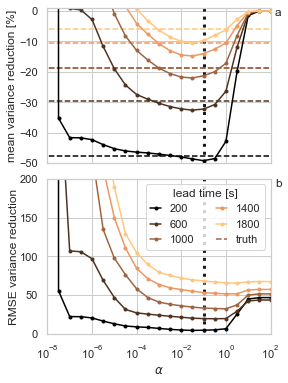

In [50]:
fig,ax=plt.subplots(2,1,figsize=(4,6),sharex='all')

for t in range(ndt_steps):
    ax[0].plot(alpha_vec,es_alpha[:,t]/total[t]*100,label=str(t_vec[t]),color=plt.cm.copper(t/(ndt_steps-1)),marker='.')
    ax[0].hlines(real[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle='--',color=plt.cm.copper(t/(ndt_steps-1)))
    
    ax[1].plot(alpha_vec,rmse_es_alpha[:,t]*real[t],label=str(t_vec[t]),color=plt.cm.copper(t/(ndt_steps-1)),marker='.')
    
    
    #plt.hlines(es[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle=':',color=plt.cm.copper(t/(ndt_steps-1)))
t=2
ax[0].hlines(real[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle='--',color=plt.cm.copper(t/(ndt_steps-1)),label='truth')
ax[1].hlines(real[t]/total[t]*100,alpha_vec[0],alpha_vec[-1],linestyle='--',color=plt.cm.copper(t/(ndt_steps-1)),label='truth')

ax[0].vlines(alpha_default,-1000,1000,linestyle=':',color='k',lw=3)
ax[1].vlines(alpha_default,-1000,1000,linestyle=':',color='k',lw=3)

#plt.legend(title='lead time [s]',bbox_to_anchor=(1,1))
# ax[0].legend(title='lead time [s]',ncol=2,bbox_to_anchor=(2,1),loc='upper right')
ax[1].legend(title='lead time [s]',ncol=2,loc='upper right',handlelength=1)
ax[0].set_xscale('log')
# ax[0].set_xlabel(r'$\alpha$')
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel('RMSE variance reduction',labelpad=0.1)
ax[0].set_ylabel('mean variance reduction [%]')
ax[0].set_ylim(top=1,bottom=-50)
ax[1].set_ylim(top=200,bottom=0)
ax[0].set_xlim(left=1e-8,right=100)
label_axes_abcd(fig,loc=(1.02,0.95))
plt.subplots_adjust(hspace=0.1)
fig.align_labels()
ax[0].yaxis.get_label().set_verticalalignment("baseline")
ax[0].yaxis.get_label().set_verticalalignment("baseline")
# plt.legend(title='lead time [s]',bbox_to_anchor=(-0.05,1.05,1,0.1),ncol=3)

# 2D histograms of ensemble size versus signal propagation error

In [51]:
"""
initialize model and data assimilation setup using the default values
"""
m_const = set_model_constants_22()
da_const = set_da_constants_22()
sat_operator = reflectance_simulator
da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests


In [52]:
"""
initialize model and data assimilation setup using the default values
"""

m_const = set_model_constants_22()
da_const = set_da_constants_22(nens=128,ncyc=100)
sat_operator = reflectance_simulator


In [53]:

# slight difference now, instead of running a new state for each ensemble size, i instead first run the max size ensemble, and then randomly select the desired number of ensembles from the large state.
# This is to avoid having differences in the default model run overpower the differences between how many ensembles are used for the vr  test

n_steps=6
ens_values = 2**np.arange(2,n_steps+2)
ens_values = ens_values.astype(int)
#da_const['nens'] = ens_values[-1]

In [54]:
ens_values

array([  4,   8,  16,  32,  64, 128])

In [55]:
error_vec = np.arange(2,18.5)*10
nerrors = len(error_vec)
print(error_vec)

[ 20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150.
 160. 170. 180.]


In [56]:
%%time
# Run the model
states_big   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)


/home/pgriewank/pgriewank/code/2021-linear-advection/da_functions.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  bg[:,i]    = linear_advection_model(analysis[:,i],u_ens,dhdt_ens,m_const["dx"],da_const["dt"],da_const["nt"])


CPU times: user 11.7 s, sys: 240 ms, total: 11.9 s
Wall time: 3.01 s


<!-- a_file = open("plot-data/state_letkf_512_1220.pkl", "rb") -->
<!-- states_512 = pickle.load(a_file) -->
<!-- a_file.close() -->

In [57]:
# %%time
# t_start= 40
# t_end = 100
# n_rand = 15
# # n_rand = 4
# n_samples = (t_end-t_start)*n_rand
# vr_real       = np.zeros([n_steps,n_samples]) 
# vr_es         = np.zeros([n_steps,n_samples]) 
# vr_is_cw      = np.zeros([nerrors,n_steps,n_samples])
# var_total     = np.zeros([n_steps,n_samples]) 
# for i in range(n_steps): 
#     n_ens=ens_values[i]
#     for t in range(t_start,t_end):
#         for r in range(n_rand):
#             n = (t-t_start)*n_rand+r
#             np.random.seed(n)
#             # selecting random ensemble members for the ensemble
#             idx_ens = randomized_obs_loc(n_ens,start=0,end=ens_values[-1],seed=n)
#             truth_idx = r
            
#             da_const_vr['nens'] = n_ens
            
#             vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states_big[0]['bg'][t][:,idx_ens],
#                                 states_big[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
#                                                 obs_seed=n,model_seed=n,alpha=alpha_default)
                                                
#             var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
#             vr_es[i,n]     = vr_t
#             vr_real[i,n]   = vr_r
#             for e in range(nerrors):
#                 vr_t, vr_r, quad_bla, J_dict= vr_individual_loc_22(states_big[0]['bg'][t][:,idx_ens],states_big[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,
#                                                       advect_flag=1,obs_seed=n,model_seed=n,quad_state=quad,error_u=error_vec[e])
#                 vr_is_cw[e,i,n]  = vr_t
            
            
#     print('completed nens:',ens_values[i])
# counter       =n_samples

In [58]:
# dict_raw = {

# 'vr_es   ':vr_es   ,
# 'vr_is_cw':vr_is_cw,
# 'vr_real ':vr_real ,
# 'var_total':var_total,
# 'ens_values':ens_values,
# 'error_vec':error_vec
# }

In [59]:
# a_file = open("plot-data/dict_raw_2dhist.pkl", "wb")
# pickle.dump(dict_raw, a_file)
# a_file.close()

In [60]:
dict_raw_2dhist    = pickle.load(open('./plot-data/dict_raw_2dhist.pkl','rb'))

In [61]:

vr_es     =dict_raw_2dhist['vr_es   ']
vr_is_cw  =dict_raw_2dhist['vr_is_cw']
vr_real   =dict_raw_2dhist['vr_real ']
var_total =dict_raw_2dhist['var_total']
ens_values=dict_raw_2dhist['ens_values']
error_vec =dict_raw_2dhist['error_vec']

In [62]:
# calculating the mean properties over all experiments
es    =np.mean(vr_es    ,axis=1)
real  =np.mean(vr_real  ,axis=1)
total =np.mean(var_total,axis=1)

me_es    =np.sum((vr_es    -vr_real),axis=1)/np.sum(vr_real)
# rmse_es=np.sqrt(np.mean((vr_es    -vr_real)**2))
rmse_es    =np.power(np.mean(np.power((vr_es    -vr_real),2),axis=1),0.5)#/np.sum(vr_real,axis=0)*counter

rmse_is_cw =np.zeros([nerrors,n_steps])
is_cw      =np.zeros([nerrors,n_steps])

for l in range(n_steps):
    rmse_es[l]    =np.sqrt(np.mean((vr_es[l,:]-vr_real[l,:])**2))
    for e in range(nerrors):
        rmse_is_cw[e,l] =np.sqrt(np.mean((vr_is_cw[e,l,:]    -vr_real[l,:])**2))
        is_cw[e,l]      =np.mean(vr_is_cw[e,l,:] ,axis=0)#/counter#/var_total


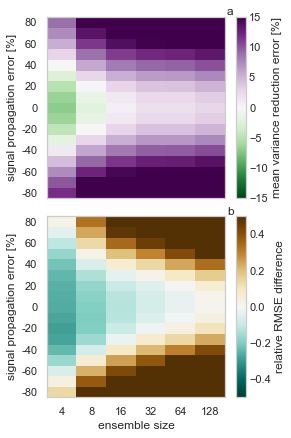

In [63]:
fig,ax = plt.subplots(2,1,figsize=(4,7),sharex='all')
A =(is_cw-real)/(total)*100 
# p1 = ax[0].pcolormesh(A,vmax=40,vmin=-40,cmap='vlag_r')
p1 = ax[0].pcolormesh(A,vmax=15,vmin=-15,cmap='PRGn_r')
# p1 = ax[0].pcolormesh(A,cmap='plasma_r')#,vmax=np.max(A),vmin=-np.max(A),cmap='vlag_r')
ax[0].set_yticks(np.arange(0,nerrors,2)+0.5)
ax[0].set_xticks(np.arange(0,n_steps,2)+0.5)
ax[0].set_xticklabels((ens_values.astype(int)[::2]),rotation=0)
ax[0].set_yticklabels(np.array(error_vec.astype(int))[::2]-100)
ax[0].set_ylabel('signal propagation error [%]')
# ax[0].set_title('explicit method, local vs global sensitivity')

A = (rmse_is_cw-rmse_es)/(rmse_es)
# p = ax[1].pcolormesh(A,vmax=np.max(A),vmin=-np.max(A),cmap='vlag_r')
p2 = ax[1].pcolormesh(A,vmax=0.5,vmin=-0.5,cmap='BrBG_r')
ax[1].set_yticks(np.arange(0,nerrors,2)+0.5)
ax[1].set_xticks(np.arange(0,n_steps)+0.5)
ax[1].set_xticklabels((ens_values.astype(int)),rotation=0)
ax[1].set_yticklabels(np.array(error_vec.astype(int))[::2]-100)
ax[1].set_xlabel('ensemble size')
ax[1].set_ylabel('signal propagation error [%]')
# ax[1].set_title('explicit method, local vs global sensitivity')
plt.subplots_adjust(hspace=0.1)
label_axes_abcd(fig,loc=(1.01,1.01))
cbar1 = plt.colorbar(p1,label='mean variance reduction error [%]',ax=ax[0])#,ticks=[-0.4,-0.2,0.0,0.2,0.4])
cbar2 = plt.colorbar(p2,label='relative RMSE difference',ax=ax[1])
cbar1.ax.tick_params(size=0)
cbar2.ax.tick_params(size=0)

# 2D histogram of rmse as a function of localization length and advection error. Marks when localizing is worse than not localizing

In [64]:
%%time
# just resetting a
m_const = set_model_constants_22()
da_const = set_da_constants_22(nens=8,ncyc=250)
sat_operator = reflectance_simulator
da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50),nens=8) #changed direct point observations for variance reduction tests
# Run the model
states   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)


CPU times: user 13.9 s, sys: 328 ms, total: 14.3 s
Wall time: 3.58 s


In [65]:
# %%time
# import time
# start_time=time.process_time()
# sens_loc_length=6000

# t_forecast=500
# t_start= 40
# t_end = 220
# n_ens = 8
# loc_vec=np.sqrt(2)**np.arange(10)*250.
# loc_steps=len(loc_vec)
# error_vec = [20,40,60,80,100,120,140,160,180]
# error_vec = np.arange(2,18.5)*10
# nerrors = len(error_vec)
# n_samples = (t_end-t_start)*n_ens
# truth_idx = 0
# vr_es        = np.zeros([n_samples])
# vr_es_cw     = np.zeros([nerrors,loc_steps,n_samples])
# vr_real      = np.zeros([n_samples]) 
# var_total     = np.zeros([n_samples]) 
# counter = 0
# for t in range(t_start,t_end):
#     for n in range(n_ens):
#         i = (t-t_start)*n_ens+n
#         counter = counter+1
#         truth_idx = n
#         vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
#                 states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
#                 obs_seed=i,model_seed=i,alpha=alpha_default)
#         var_total[i] = np.var(J_dict['bf'],ddof=1)
#         vr_es[i]     = vr_t
#         vr_real[i]   = vr_r
#         for dl in range(len(loc_vec)): 
#             for e in range(nerrors):
#                 vr_t, vr_i, vr_r,J_dict,dJdx_inv, bla_quad, dx = vr_reloaded_22_locsens(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,sens_loc_flag=1,
#                                                                  sens_loc_adv_error=error_vec[e],sens_loc_length=loc_vec[dl],
#                                                                  obs_seed=i,model_seed=i,quad_state=quad)
#                 vr_es_cw[e,dl,i]  = vr_t
            
#     if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))

In [66]:
# dict_raw = {

# 'vr_es   ':vr_es   ,
# 'vr_es_cw':vr_es_cw,
# 'vr_real ':vr_real ,
# 'var_total':var_total,
# 'loc_vec':loc_vec,
# 'error_vec':error_vec
# }

In [67]:
# a_file = open("plot-data/dict_raw_2dhist_sensloc.pkl", "wb")
# pickle.dump(dict_raw, a_file)
# a_file.close()

In [68]:
dict_raw_2dhist2    = pickle.load(open('./plot-data/dict_raw_2dhist_sensloc.pkl','rb'))

In [69]:

vr_es     =dict_raw_2dhist2['vr_es   ']
vr_es_cw  =dict_raw_2dhist2['vr_es_cw']
vr_real   =dict_raw_2dhist2['vr_real ']
var_total =dict_raw_2dhist2['var_total']
loc_vec   =dict_raw_2dhist2['loc_vec']
error_vec =dict_raw_2dhist2['error_vec']
nerrors = len(error_vec)
loc_steps = len(loc_vec)

In [70]:
# calculating the mean properties over all experiments
es    =np.mean(vr_es    ,axis=0)
real  =np.mean(vr_real  ,axis=0)
total =np.mean(var_total,axis=0)

me_es    =np.sum((vr_es    -vr_real))/np.sum(vr_real)
rmse_es=np.sqrt(np.mean((vr_es    -vr_real)**2))

rmse_es_cw =np.zeros([nerrors,loc_steps])
es_cw      =np.zeros([nerrors,loc_steps])

for e in range(nerrors):
    for l in range(loc_steps):
        rmse_es_cw[e,l] =np.sqrt(np.mean((vr_es_cw[e,l,:]    -vr_real)**2))
        es_cw[e,l] =np.mean(vr_es_cw[e,l,:] ,axis=0)#/var_total



Text(0.5, 1.0, 'explicit method, local vs global sensitivity')

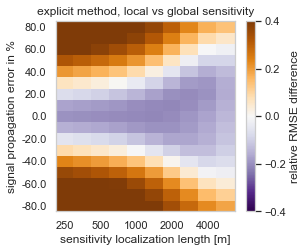

In [71]:
fig,ax = plt.subplots(1,1,figsize=(4.,3.5))
A = (rmse_es_cw-rmse_es)/np.abs(rmse_es)

# plt.pcolormesh(A,vmax=np.max(A),vmin=-np.max(A),cmap='PiYG_r')
plt.pcolormesh(A,vmax=0.4,vmin=-0.4,cmap='PuOr_r')
plt.colorbar(label='relative RMSE difference',ticks=[-0.4,-0.2,0.0,0.2,0.4])
ax.set_yticks(np.arange(0,nerrors,2)+0.5)
ax.set_xticks(np.arange(0,loc_steps,2)+0.5)
ax.set_xticklabels((loc_vec.astype(int)[::2]),rotation=0)
ax.set_yticklabels(np.array(error_vec)[::2]-100)
ax.set_xlabel('sensitivity localization length [m]')
ax.set_ylabel('signal propagation error in %')
ax.set_title('explicit method, local vs global sensitivity')

# Code to reproduce the localization length, lead time, and ensemble plots 

### ens size

In [72]:
# """
# initialize model and data assimilation setup using the default values
# """

# m_const = set_model_constants_22()
# da_const = set_da_constants_22(nens=512,ncyc=100)
# sat_operator = reflectance_simulator
# n_rand = 60

In [73]:
# # slight difference now, instead of running a new state for each ensemble size, i instead first run the max size ensemble, and then randomly select the desired number of ensembles from the large state.
# # This is to avoid having differences in the default model run overpower the differences between how many ensembles are used for the vr  test
# n_steps=8
# ens_values = 2**np.arange(2,n_steps+2)
# ens_values = ens_values.astype(int)

In [74]:
# %%time
# # Run the model
# states_big   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)


In [75]:
# %%time
# da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests



# n_samples = (t_end-t_start)*n_rand
# counter =n_samples
# vr_real       = np.zeros([n_steps,n_samples]) 
# vr_es         = np.zeros([n_steps,n_samples]) 
# vr_es_reg     = np.zeros([n_steps,n_samples]) 
# vr_is_ca      = np.zeros([n_steps,n_samples]) 
# vr_es_ca      = np.zeros([n_steps,n_samples]) 
# var_total     = np.zeros([n_steps,n_samples]) 
# for i in range(n_steps): 
#     nn_ens=ens_values[i]
#     for t in range(t_start,t_end):
#         for r in range(n_rand):

#             n = (t-t_start)*n_rand+r
#             np.random.seed(n)
#             # selecting random ensemble members for the ensemble
#             idx_ens = randomized_obs_loc(nn_ens,start=0,end=ens_values[-1],seed=n)
#             truth_idx = idx_ens[np.random.randint(0,nn_ens)]

#             da_const_vr['nens'] = nn_ens
         
            
            
#             vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states_big[0]['bg'][t][:,idx_ens],
#                                 states_big[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
#                                                 obs_seed=n,model_seed=n,alpha=alpha_default)
                                                
#             var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
#             vr_real[i,n]   = vr_r
#             vr_es[i,n]     = vr_t
            
#             vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states_big[0]['bg'][t][:,idx_ens],
#                                 states_big[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
#                                                 obs_seed=n,model_seed=n,alpha=1,quad_state=quad)
                                                
#             vr_es_reg[i,n]     = vr_t
#             vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states_big[0]['bg'][t][:,:],
#                             states_big[0]['bg'][t][:,truth_idx],m_const,da_const_vr,sat_operator,
#                                                                    advect_flag=1,quad_state=quad,
#                                                                    obs_seed=n,model_seed=n)
#             vr_is_ca[i,n]  = vr_t
#             vr_t, vr_i, vr_r,J_dict,dJdx_inv, bla_quad, dx = vr_reloaded_22_locsens(states_big[0]['bg'][t][:,idx_ens],states_big[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,sens_loc_flag=1,
#                                         sens_loc_length=sens_loc_length,
#                                         obs_seed=n,model_seed=n,quad_state=quad)
#             vr_es_ca[i,n]  = vr_t
            
#     print('completed nens:',ens_values[i])

### lead time

In [76]:
# %%time
# # just resetting a
# m_const = set_model_constants_22()
# da_const = set_da_constants_22()
# sat_operator = reflectance_simulator
# da_const_vr = set_da_constants_22(obs_loc=np.arange(25,299,50)) #changed direct point observations for variance reduction tests
# # Run the model
# states   = run_linear_advection_KF_22(m_const,da_const,reflectance_simulator)


In [77]:
# %%time
# import time
# start_time=time.process_time()

# ndt_steps=6
# ndt_steps=11
# t_vec=np.linspace(0,1000,ndt_steps)
# n_samples = (t_end-t_start)*n_rand
# truth_idx = 0
# vr_es        = np.zeros([ndt_steps,n_samples])
# vr_es_ca     = np.zeros([ndt_steps,n_samples])
# vr_is_ca     = np.zeros([ndt_steps,n_samples])
# vr_real      = np.zeros([ndt_steps,n_samples]) 
# var_total    = np.zeros([ndt_steps,n_samples]) 
# ref_t = da_const['dt']
# t_vec[0] = 1
# counter = 0


# for t in range(t_start,t_end):
#     for n in range(n_rand):
#         i = (t-t_start)*n_rand+n
#         counter = counter+1
#         truth_idx = n
#         for dt in range(len(t_vec)): 
#             da_const_vr['dt'] = t_vec[dt]
            
#             vr_t, vr_i, vr_r,J_dict,dJdx_inv, quad, dx = vr_reloaded_22(
#                 states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,
#                 obs_seed=i,model_seed=i,alpha=alpha_default)
#             var_total[dt,i] = np.var(J_dict['bf'],ddof=1)
#             vr_es[dt,i]     = vr_t
#             vr_real[dt,i]   = vr_r

#             vr_t, vr_i, vr_r,J_dict,dJdx_inv, bla_quad, dx = vr_reloaded_22_locsens(states[0]['bg'][t],states[0]['bg'][t][:,n],m_const,da_const_vr,reflectance_simulator,sens_loc_flag=1,
#                                                                  sens_loc_length=sens_loc_length,
#                                                                  obs_seed=i,model_seed=i,quad_state=quad)
#             vr_es_ca[dt,i]     = vr_t
            
#             vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states[0]['bg'][t],
#                             states[0]['bg'][t][:,n],m_const,da_const_vr,sat_operator,
#                                                     advect_flag=1,quad_state=quad,obs_seed=i,model_seed=i)
#             vr_is_ca[dt,i]  = vr_t
            
            
            
#     if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))

### localization length

In [78]:
# %%time
# import time
# start_time=time.process_time()


# n_samples = (t_end-t_start)*n_rand
# truth_idx = 0

# loc_values = 2.**np.arange(11)*m_const['dx']
# vr_es        = np.zeros([11,n_samples])
# vr_es_ca     = np.zeros([11,n_samples])
# vr_is_ca     = np.zeros([11,n_samples])
# vr_real      = np.zeros([11,n_samples]) 
# var_total     = np.zeros([11,n_samples]) 
# counter = 0
# for t in range(t_start,t_end):
#     for r in range(n_rand):
#         n = (t-t_start)*n_rand+r
#         np.random.seed(n)
#         counter = counter+1
#         truth_idx = r
#         for i in range(len(loc_values)): 
                
#             da_const_vr = set_da_constants_22(loc_length=loc_values[i],obs_loc=np.arange(25,299,50))
            
#             vr_t, vr_i, vr_r, J_dict_LA,bla, quad,dx_ni =vr_reloaded_22(states[0]['bg'][t],states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,iterative_flag = 0,
#                                                                         obs_seed=counter,model_seed=counter,alpha=alpha_default)
#             var_total[i,n] = np.var(J_dict_LA['bf'],ddof=1)
#             vr_es[i,n]     = vr_t
#             vr_real[i,n]   = vr_r
            
#             vr_t, vr_i, vr_r,J_dict,dJdx_inv, bla_quad, dx = vr_reloaded_22_locsens(states[0]['bg'][t],states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,sens_loc_flag=1,
#                                                                  sens_loc_length=sens_loc_length,
#                                                                  obs_seed=i,model_seed=i,quad_state=quad)
#             vr_es_ca[i,n]     = vr_t
            
#             vr_t, vr_r, quad, J_dict_LA     = vr_individual_loc_22(states[0]['bg'][t],states[0]['bg'][t][:,truth_idx],m_const,da_const_vr,reflectance_simulator,advect_flag=1,quad_state=quad,obs_seed=counter,model_seed=counter)
#             vr_is_ca[i,n]  = vr_t
#     if np.floor(t/10) == t/10: print('completed timesteps:',t-39,' seconds spent computing so far:',np.floor(time.process_time()-start_time))
       